# Notes about simulation:

$$MAP3K_I = MAP3K_t-MAP3K$$
$$MAP2K_I = MAP2K_t-MAP2K$$
$$MAPK_I = MAPK_t-MAPK$$


$$\dfrac{dMAP3K}{dt} = \dfrac{ s}{1+\dfrac{MAPK}{\beta}} \cdot \dfrac{k1\cdot MAP3K_I}{K_1 + MAP3K_I} - \dfrac{k2\cdot MAP3K}{K_2+MAP3K}$$

$$\dfrac{dMAP2K}{dt} = \dfrac{k3\cdot MAP3K\cdot MAP2K_I}{K_3 + MAP2K_I} - \dfrac{k4\cdot MAP2K}{K_4+MAP2K}$$

$$\dfrac{dMAPK}{dt} = \dfrac{k5\cdot MAP2K\cdot MAPK_I}{K_5 + MAPK_I} - \dfrac{k6\cdot MAPK}{K_6+MAPK}$$


# Import packages and set settings

In [1]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import os
import itertools

In [2]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

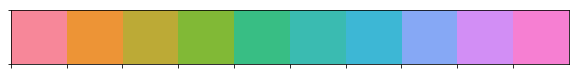

In [4]:
sns.palplot(sns.husl_palette(10, l=.7))
palette_husl = sns.husl_palette(10, l=.7)
# palette_husl.as_hex()
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()

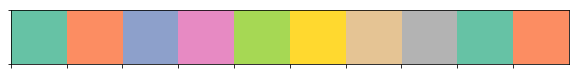

In [100]:
sns.palplot(sns.color_palette('Set2',10))

In [5]:
# reds = sns.color_palette("Reds",15)
# reds.as_hex()

# Globals

## Color palettes

In [3]:
map3k = {0:'#323232', 50000:'#606060', 150000:'#84bcdb', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#084082'}
hog1 = {0:'#323232', 50000:'#606060', 150000:'#8ace88', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#005723'}
pbs2 = {0:'#323232', 50000:'#606060', 150000:'#84bcdb', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#084082'}
osmolytes = {0:'#323232', 50000:'#606060', 150000:'#84bcdb', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#084082'}
ptps = {0:'#323232', 50000:'#606060', 150000:'#84bcdb', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#084082'}

color_palettes = {0: map3k, 1: pbs2, 2: hog1, 3:osmolytes, 4:ptps, 'random': sns.color_palette('Set2',24)}
species_names = {0: 'active MAP3K', 1: 'ppPbs2', 2: 'ppHog1', 3:'Osmolyte', 4:'Ptps'}

## Load data to fit to

In [4]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
# pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/pulse_pbs2'

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

mapk_time, mapk_wt_data = load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)
mapk_time, map2k_wt_data = load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = load_csv_data(pbs2_t100a_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
mapk_ramp_time, hog1_ramp_data = load_csv_data(hog1_ramp_folder)
# mapk_pulse_time, pbs2_pulse_data = load_csv_data(pbs2_pulse_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]


# scorefxn_data = [mapk_wt_data]
# scorefxn_time = [mapk_time]

# Functions

In [5]:
# def get_closest_tps(scorefxn_time,time):
#     idx_closest_time_points = []
#     for each_time in scorefxn_time:
#         closest_idx = min(range(len(time)),
#                           key = lambda i: abs(time[i] - each_time))
#         idx_closest_time_points.append(closest_idx)
#     return idx_closest_time_points

# # def convert_individual(ea_individual, conversion_matrix, number_of_params):
#     # copy and get len of individual
#     arr_params_conv = np.zeros(number_of_params)#np.copy(arr_parameters)
#     len_ind = len(ea_individual)

    # Interp:
#     for idx in np.nonzero(conversion_matrix[0])[0]:
#         ea_val = ea_individual[idx]
#         r_min = conversion_matrix[1][idx]
#         r_max = conversion_matrix[2][idx]
#         arr_params_conv[idx] = np.interp(ea_val, (0,1), (r_min, r_max))

#     # Exponentiate:
#     for idx in np.nonzero(conversion_matrix[3])[0]:
#         ea_val = arr_params_conv[idx]
#         base_val = conversion_matrix[4][idx]
#         arr_params_conv[idx] = np.power(base_val, ea_val)

#     # arr_params_conv[-4:] = np.round(arr_params_conv[-4:],0)

#     return arr_params_conv

# def scorefxn2(scorefxn_data, inits, params_constants,
#               learned_params, time, scorefxn_time):
#     sse_total = 0
# #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

#     for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
#         params_constants_sig = params_constants[:-1]+[sig]

#         for fxn, exp_data in zip([simulate_wt_experiment,simulate_t100a_experiment],[MAPK_wt_data, MAPK_t100a_data]):
#             data = fxn(inits, params_constants_sig, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             _scorefxn_data_active = active[[scorefxn_time]]
#             error_active = ((exp_data - _scorefxn_data_active)**2).sum()
#             sse_total += error_active
#     return sse_total/(len(idx_closest_time_points)*len(params_constants[-1])-len(learned_params))

# def scorefxn1(scorefxn_data, inits, params_constants,
#               learned_params, time, scorefxn_time):
#     sse_total = 0
# #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

#     for sig, MAPK_wt_data, MAPK_t100a_data in zip(params_constants[-1], scorefxn_data[0], scorefxn_data[1]):
#         params_constants_sig = params_constants[:-1]+[sig]

#         for fxn, exp_data in zip([simulate_wt_experiment,simulate_t100a_experiment],[MAPK_wt_data, MAPK_t100a_data]):
#             data = fxn(inits, params_constants_sig, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             _scorefxn_data_active = active[[scorefxn_time]]
#             error_active = ((exp_data - _scorefxn_data_active)**2).mean()
#             sse_total += error_active
#     return sse_total

def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44
    return molecules/(Na*cell_volume*10**-15)*1000000

def gather_simulated_data(folder, gen, runs, top_plotting):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1

    top = round((runs-empty_data)*top_plotting)
    plt_top = round((runs-empty_data)*top_plotting)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
#     last_mses = last_mses
    new_params = np.asarray(new_params)
    new_params = new_params.T

    idx_top = last_mses.argsort()[:top]

    top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
    # top_params = []
    # for idx in idx_top:
    #     top_params.append(params_from_file[idx][100])

    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses

def plt_param_behaviors(wt_dataset, t100a_dataset, ode_fxn, gen, plt_top, top_params, 
                        params_constants, initials, time, doses, species):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))
    color_palette = color_palettes.get(species)
    species_name = species_names.get(species)

    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Best fits to WT kinase dose data'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time (min)', fontsize=16)
    ax1.set_ylabel('% '+str(species_name), fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    
    
    
    for sig, data in zip(doses, wt_dataset):
        ax1.plot(mapk_time, data, 'o', markersize=10, color=color_palette.get(sig), label = str(int(sig/1000))+'mM KCl')
#     ax1.legend()
        
    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time (min)', fontsize=16)
    ax2.set_ylabel('% pppHog1', fontsize=16)
    
    for sig, data in zip(doses, t100a_dataset):
        ax2.plot(mapk_time, data, '^', mew=2, markersize=10, color=color_palette.get(sig))

#     ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for sig in doses:
        for params in top_params[:plt_top]:
#         for sig in doses:
            data = simulate_wt_experiment(initials, params_constants, sig, params, time, ode_fxn)
            active = data[:,species]/params_constants[species]*100
            ax1.plot(time, active, color=color_palette.get(sig))
            
            data = simulate_t100a_experiment(initials, params_constants, sig, params, time, ode_fxn)
            t100a = data[:,species]/params_constants[species]*100
            ax2.plot(time, t100a, '--', color=color_palette.get(sig))
#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/Hog1.png",dpi=300,bbox_inches='tight')
    plt.show()
    
def plt_param_behaviors_ramp(wt_dataset, t100a_dataset, gen, plt_top, top_params, 
                        total_protein, initials, time, species):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))
    color_palette = color_palettes.get('random')

    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
#     title_text = 'Best fits to WT kinase dose data'
#     ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time (min)', fontsize=16)
    ax1.set_ylabel('% ppHog1', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    
    
    
#     for data in ramp_dataset:
    ax1.plot(mapk_ramp_time, wt_dataset, 'o', markersize=10, color='#323232', label = 'ramp')
#     ax1.legend()
        
    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
#     title_text = 'Best fits to kinase dead mutant dose data'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time (min)', fontsize=16)
#     ax2.set_ylabel('% pppHog1', fontsize=16)
    
#     for sig, data in zip(doses, t100a_dataset):
#         ax2.plot(mapk_time, data, '^', mew=2, markersize=10, color=color_palette.get(sig))

#     ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    for i, params in enumerate(top_params[:plt_top]):
#         for sig in doses:
        data = simulate_ramp_experiment(initials, total_protein, params, time)
        active = data[:,species]/params_constants[species]*100
        ax1.plot(time, active, color=color_palette[i])

#         data = simulate_t100a_experiment(initials, params_constants, sig, params, time, ode_fxn)
#         t100a = data[:,species]/params_constants[species]*100
#         ax2.plot(time, t100a, '--', color=color_palette.get(sig))
#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/Hog1.png",dpi=300,bbox_inches='tight')
    plt.show()
    

    
# def plt_prediction(gen, idx_top, plt_top, params_from_file,params_constants, initals, time):
#     plt.clf()
#     fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,18))


#     # plot 1
#     title_text = 'Gen ' + str(gen) + ' fit to WT'
#     ax1.set_title(title_text, fontsize=20)
#     ax1.set_xlabel('Time', fontsize=20)
#     plt.rc('xtick', labelsize=20) 
#     plt.rc('ytick', labelsize=20)
#     color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
        
#     # plot 2
#     title_text = 'Gen ' + str(gen) +  ' fit to T100A + inhib'
#     ax2.set_title(title_text, fontsize=20)
#     ax2.set_xlabel('Time', fontsize=20)
    

#     # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
#     # plot evolutionary algorithm data on plots 1 and 2:
#     unstable_wt = 0
#     unstable_t100a = 0
#     for idx in idx_top[:plt_top]:
#         learned_params = params_from_file[idx][gen]
#         for sig in params_constants[-1]:
#             params_c = params_constants[:-1]+[sig]
#             data = simulate_wt_experiment(initals, params_c, sig, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax1.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_wt += 1
#             data = simulate_t100a_experiment(initals, params_c, learned_params, time)
#             active = data[:,2]/params_constants[2]*100
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
#                 ax2.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_t100a += 1
#     print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
#     print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
#     # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.show()
    
def plt_X_behaviors(gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Best fits to WT kinase dose data'
#     ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=16)
    ax1.set_ylabel('X (uM)', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
        
    # plot 2
    title_text = 'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time', fontsize=16)
    ax2.set_ylabel('X (uM)', fontsize=16)

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    unstable_wt = 0
    unstable_t100a = 0
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in [0, 150000, 550000]:
            params_c = params_constants[:-1] + [sig]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time)
            active = data[:,3]
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax1.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_wt += 1
            data = simulate_t100a_experiment(initals, params_c, sig, learned_params, time)
            active = data[:,3]
#             if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
            ax2.plot(time, active, color=color_palette.get(sig))
#             else:
#                 unstable_t100a += 1
    print('# of unstable WT experiments: ' + str(unstable_wt) + ' of ' + str(plt_top*6))
    print('# of unstable T100A experiments: ' + str(unstable_t100a) + ' of ' + str(plt_top*6))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()
    
    #plot3 
def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    colors2 = sns.color_palette("Greys", 20)[10:]
    pal2 = sns.set_palette(colors2)
    ax3.set_xlabel('Generation', fontsize=20)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_ylabel('SSE', fontsize=20)
    ax3.set_xlim([0,gen])
#     ax3.set_ylim([10**3,10**5])
    plt.show()
    

def plot_param_ranges(colors3, labelnames, diff, minimums, df_top_params_log_M):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    pal3 = sns.set_palette(colors3)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('SMSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# def get_synthdata(data, ):
    
def get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,num):
    opt_tps = list(itertools.chain.from_iterable(opt_data_mapk.values()))
    smse = []
    for params in top_params[:num]:
        smse_total = 0
        #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

        for sig, tps, MAPK_wt_data in zip(list(opt_data_mapk.keys()), list(opt_data_mapk.values()), wt_data_synth):
            params_constants_sig = params_constants[:-1]+[sig]
            for fxn in [simulate_wt_experiment]:
                data = fxn(initals, params_constants_sig, params, tps)
                active = data[:,2]/params_constants[2]*100
        #         print(MAPK_wt_data, active)
                error_active = ((MAPK_wt_data - active)**2).mean()
                smse_total += error_active
                if sig == 550000:
                    data = fxn(initals, params_constants_sig, params, mapk_time)
                    map2k = data[:,1]/params_constants[1]*100
                    if any(x > 20 for x in map2k):
    #                     print(map2k)
                        continue
                    else:
                        smse_total += 5000
        smse.append(smse_total)
    idx_synth_param = sorted(range(len(smse)), key=lambda k: smse[k])
    return top_params[idx_synth_param[0]]

In [6]:
def plt_X_behaviors_pulse(gen, idx_top, plt_top, params_from_file, 
                        params_constants, initals, time):
    plt.clf()
    fig, (ax1) = plt.subplots(2, 1, figsize=(12,9))


    # plot 1
    title_text = 'Gen ' + str(gen) + ' X'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time', fontsize=20)
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    color_palette = {0:'#000000',50000:'#606060',150000:'#ff0000',250000:'#FF8C00',350000:'#008000',450000:'#0000FF',550000:'#800080'}
    
#     for sig, wt_data in zip(params_constants[-1], mapk_wt_data):
#         ax1.plot(scorefxn_time[2], wt_data, 'o', markersize=10, color=color_palette.get(sig))

    # ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    
    
    # plot evolutionary algorithm data on plots 1 and 2:
    for idx in idx_top[:plt_top]:
        learned_params = params_from_file[idx][gen]
        for sig in params_constants[-1]:
            params_c = params_constants[:-1]
            data = simulate_wt_experiment(initals, params_c, sig, learned_params, time, signal_periodic, 10)
            active = data[:,3]/params_constants[3]*100
            if len([*filter(lambda x: x <= 100, active)]) == len(active) and len([*filter(lambda x: x >= 0, active)]) == len(active):
                ax1.plot(time, active, color=color_palette.get(sig))
    # ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
    plt.show()

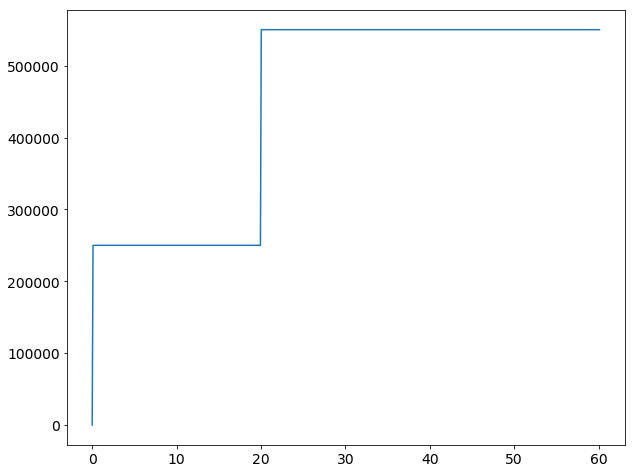

In [7]:
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

plt.plot(time,[signal_ramp_special(x) for x in time])

# No Delay

## 0A - Hog1, Hog1T100A, Pbs2, Pbs2(Hog1T100A) 

### Functions

In [8]:
def sb_0D_a0(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK = initials
    MAP3K_t, MAP2K_t, MAPK_t, fb = total_protein
    beta_3, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (sig/(1+MAPK/beta_3)**fb) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))

    return dMAP3K, dMAP2K, dMAPK

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time, ode_fxn):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(ode_fxn, inits, time, args=(total_protein, sig, learned_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time, ode_fxn):
    MAP3K_t, MAP2K_t, MAPK_t, fb = total_protein
    total_protein = MAP3K_t, MAP2K_t, MAPK_t, 0

#     beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
#     learned_params = beta_3, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6
    #solve odes:
    odes = odeint(ode_fxn, inits, time, args=(total_protein, sig, learned_params))

    return odes

def sb_0D_a0_ramp(initials,t,total_protein,params):
    
    sig = signal_ramp_special(t)

    MAP3K, MAP2K, MAPK = initials
    MAP3K_t, MAP2K_t, MAPK_t, fb = total_protein
    beta_3, k1, k3, k5, k2, k4, k6, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (sig/(1+MAPK/beta_3)**fb) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))

    return dMAP3K, dMAP2K, dMAPK

def simulate_ramp_experiment(inits, total_protein, learned_params, time):

    odes = odeint(sb_0D_a0_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

### Inputs

In [9]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/figures/fig2/190509_b3_aN_0D/'

run_name = 'sb_0D_a0'
gen = 5000
runs = 2000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_s = [150000, 550000]


labelnames = ['-fb',
              'V1', 'V3', 'V5', 
              'V2', 'V4', 'V6', 
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-4, 
    -4, -4, -4, 
    -4, -4, -4, 
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 4,
    4, 4, 4,
    4, 4, 4, 
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

fb = 1
initials = [MAP3K, MAP2K, MAPK]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, fb] 

### Gather simulated data

In [10]:
idx_top, top_params_0D_aN, top, plt_top, new_params, params_from_file, mse_0D_aN, last_mses_0D_aN = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_0D_aN)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 3578.854366169519
Mean MSE of top 5%: 3984.6407196389496


### Plot

<Figure size 720x576 with 0 Axes>

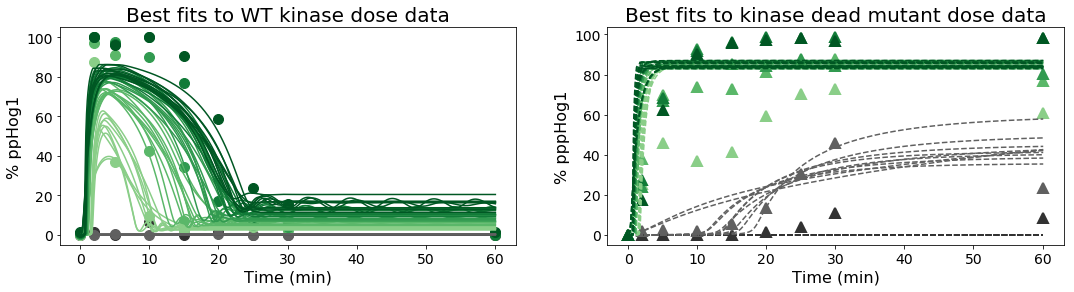

In [11]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, sb_0D_a0, gen, 10, top_params_0D_aN, 
                        params_constants, initials, time, s, 2)

<Figure size 720x576 with 0 Axes>

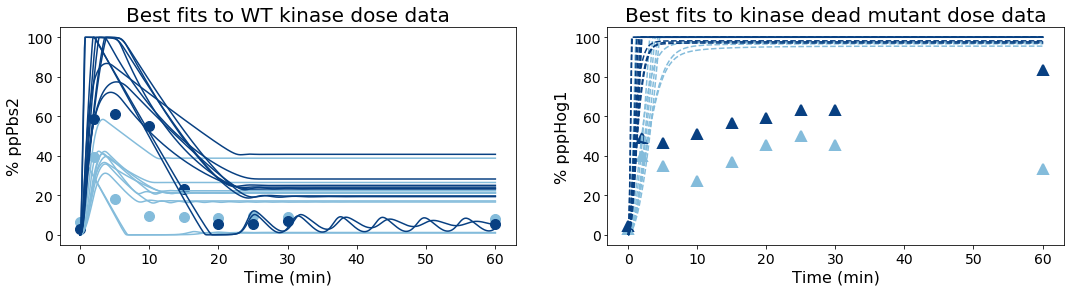

In [12]:
plt_param_behaviors(map2k_wt_data, map2k_t100a_data, sb_0D_a0, gen, 10, top_params_0D_aN, 
                        params_constants, initials, time, map2k_s, 1)

<Figure size 720x576 with 0 Axes>

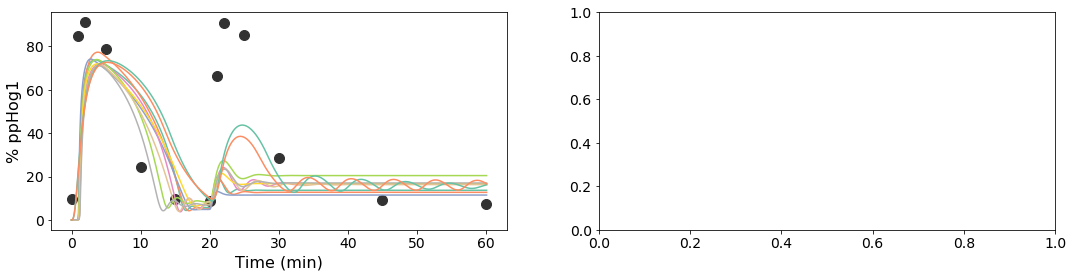

In [13]:
plt_param_behaviors_ramp(hog1_ramp_data[0],__, gen, 10, top_params_0D_aN, 
                         params_constants, initials,time, 2)#scorefxn_time[2])

In [ ]:
plt_mses_gen(gen,mse_0D_aN)

In [ ]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

## 0A 

### Functions

### Inputs

### Gather simulated data

### Plot

# One Step Delay

## 0A - Hog1, Hog1T100A, Pbs2, Pbs2(Hog1T100A) 

### Functions

In [132]:
def sb_1D_a0(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, X = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6 = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (sig/(1+X/beta_3)) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time, ode_fxn):

    odes = odeint(ode_fxn, inits, time, args=(total_protein, sig, learned_params))

    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time, ode_fxn):
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = learned_params
    learned_params = beta_3, k1, k3, k5, 0, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6

    odes = odeint(ode_fxn, inits, time, args=(total_protein, sig, learned_params))

    return odes

def sb_1D_a0_ramp(initials,t,total_protein,params):
    
    sig = signal_ramp_special(t)

    MAP3K, MAP2K, MAPK, X = initials
    MAP3K_t, MAP2K_t, MAPK_t, _ = total_protein
    beta_3, k1, k3, k5, s7, k2, k4, k6, d8, K_1, K_3, K_5, K_2, K_4, K_6  = params

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK

    dMAP3K = (sig/(1+MAPK/beta_3)**fb) * (((k1)*MAP3K_I)/(K_1+MAP3K_I)) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - (k6*MAPK/(K_6+MAPK))
    dX = s7*MAPK - d8*X

    return dMAP3K, dMAP2K, dMAPK, dX

def simulate_ramp_experiment(inits, total_protein, learned_params, time):

    odes = odeint(sb_1D_a0_ramp, inits, time, args=(total_protein, learned_params))
    return odes

### Inputs

In [138]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/figures/fig2/190510_b3_aN_1D/'

run_name = 'sb_0D_a0'
gen = 5000
runs = 2000 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)


s = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_s = [150000, 550000]


labelnames = ['-fb',
              'V1', 'V3', 'V5', 'S7',
              'V2', 'V4', 'V6', 'D8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-4, 
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 4,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

initials = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 

### Gather simulated data

In [144]:
idx_top, top_params_1D_aN, top, plt_top, new_params, params_from_file, mse_1D_aN, last_mses_1D_aN = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_1D_aN)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 1870.213186946041
Mean MSE of top 5%: 2587.407551617405


### Plot

<Figure size 720x576 with 0 Axes>

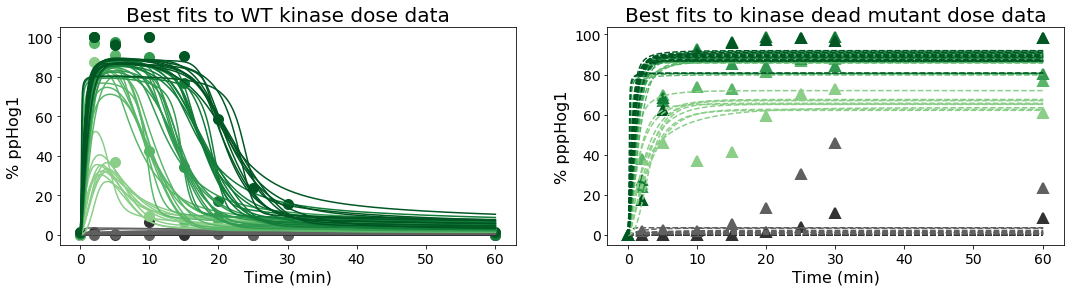

In [128]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, sb_1D_a0, gen, 10, top_params_1D_aN, 
                        params_constants, initials, time, s, 2)

<Figure size 720x576 with 0 Axes>

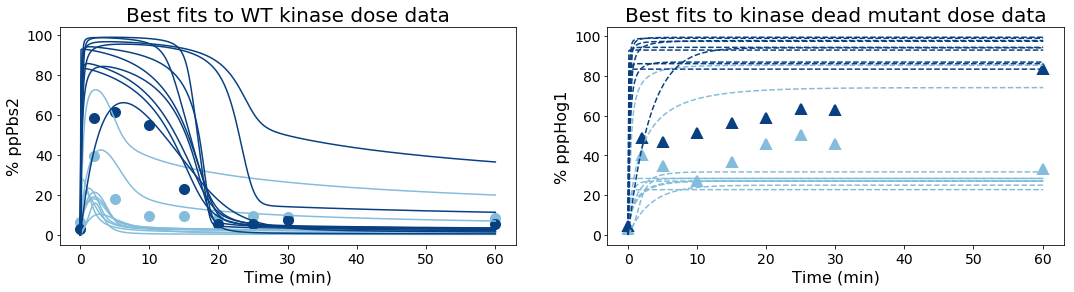

In [130]:
plt_param_behaviors(map2k_wt_data, map2k_t100a_data, sb_1D_a0, gen, 10, top_params_1D_aN, 
                        params_constants, initials, time, map2k_s, 1)

<Figure size 720x576 with 0 Axes>

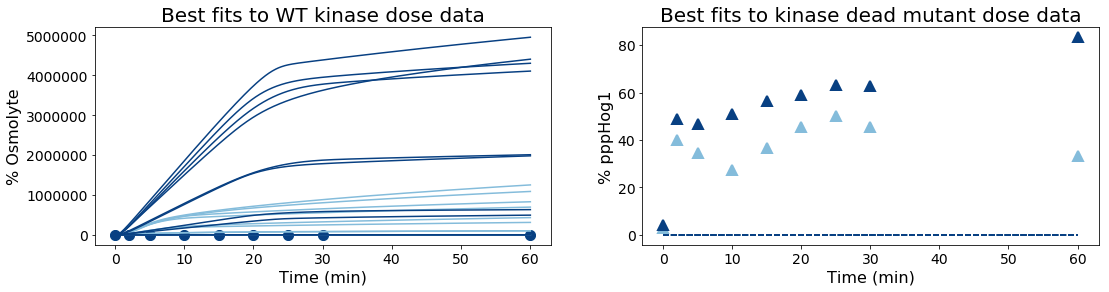

In [134]:
plt_param_behaviors(map2k_wt_data, map2k_t100a_data, sb_1D_a0, gen, 10, top_params_1D_aN, 
                        params_constants, initials, time, map2k_s, 3)

<Figure size 864x576 with 0 Axes>

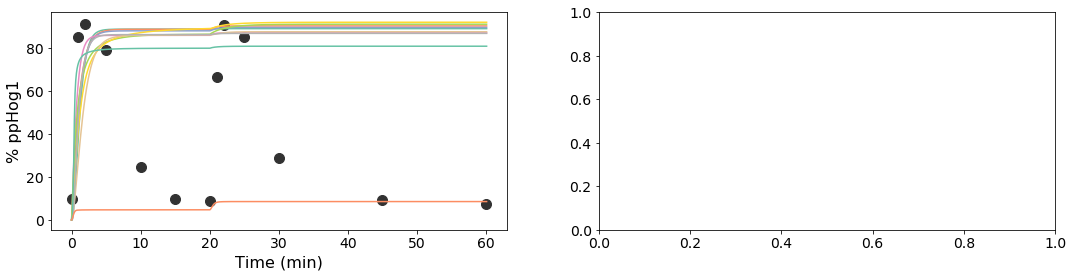

In [142]:
plt_param_behaviors_ramp(hog1_ramp_data[0],__, gen, 10, top_params_1D_aN, 
                         params_constants, initials,time, 2)#scorefxn_time[2])

<Figure size 864x576 with 0 Axes>

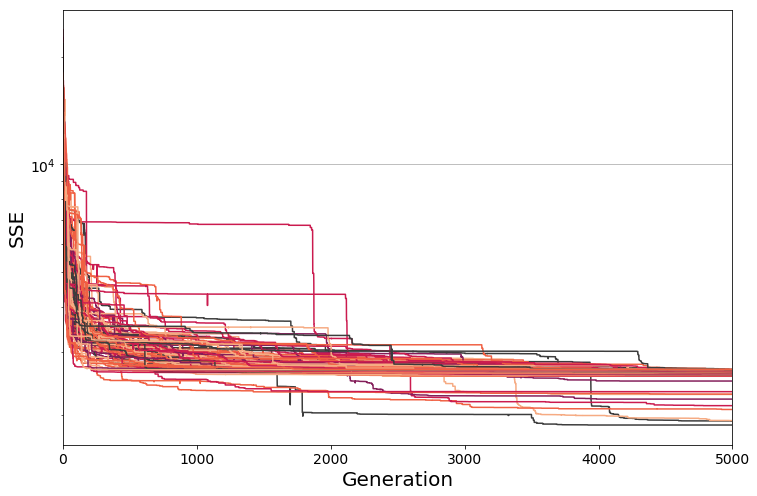

In [145]:
plt_mses_gen(gen,mse_1D_aN)

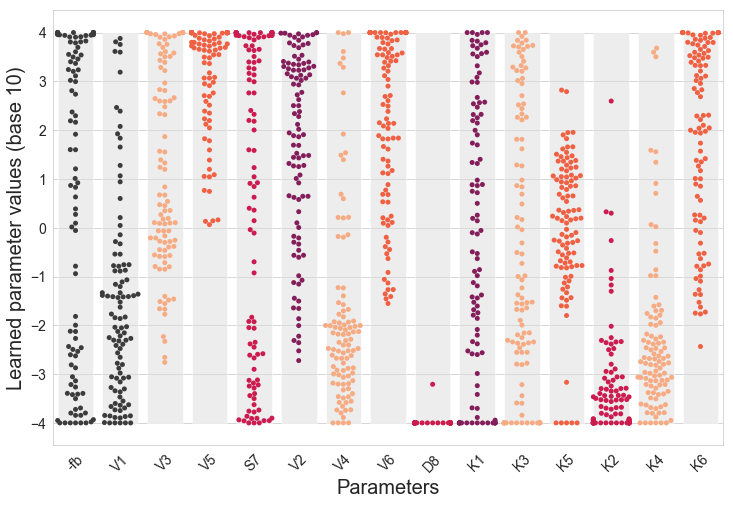

In [146]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

### Inputs

In [121]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/scripts/synth_deg/1_pass/181025_b3_1D_a1/'
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190218_a1_map2k_ramp/'

run_name = 'b3_1D_a1'
gen = 250
runs = 4 #984

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0

MAP3K_t = molarity_conversion(704)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
X_t = 1

s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['-fb', '+MAPK',
              'k1', 'k3', 'k5', 'k7',
              'k2', 'k4', 'k6', 'k8',
              'K1', 'K3', 'K5', 
              'K2', 'K4', 'K6'
                ]

minimums = [-8, 
    -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4]

maximums = [ 2,
    4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0
fb = 1
initals = [MAP3K, MAP2K, MAPK, X]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, fb, s] 

### Gather simulated data

In [89]:
idx_top, top_params_aN_1D, top, plt_top, new_params, params_from_file, mse_aN_1D, last_mses_aN_1D = gather_simulated_data(folder, gen, runs, 1)
df_top_params = pd.DataFrame(top_params_aN_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 42647.63128834257
Mean MSE of top 5%: 42861.72926526492


### Plot

# of unstable WT experiments: 0 of 60
# of unstable T100A experiments: 0 of 60


<Figure size 864x576 with 0 Axes>

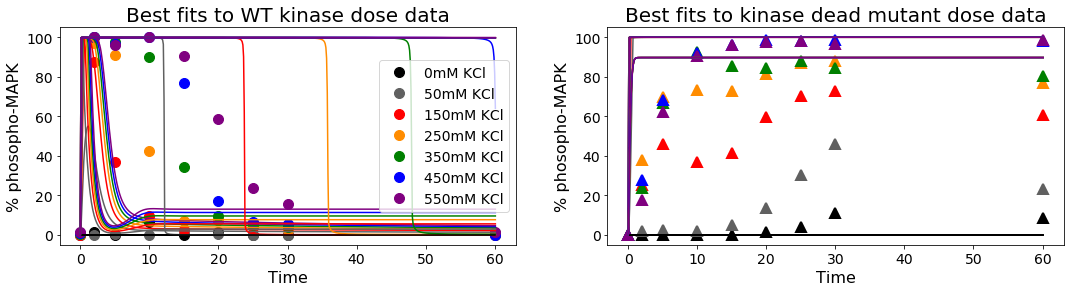

In [90]:
plt_param_behaviors(mapk_wt_data, mapk_t100a_data, gen, idx_top, 10, params_from_file, 
                        params_constants, initals, time)

TypeError: simulate_wt_experiment() takes 5 positional arguments but 7 were given

<Figure size 864x576 with 0 Axes>

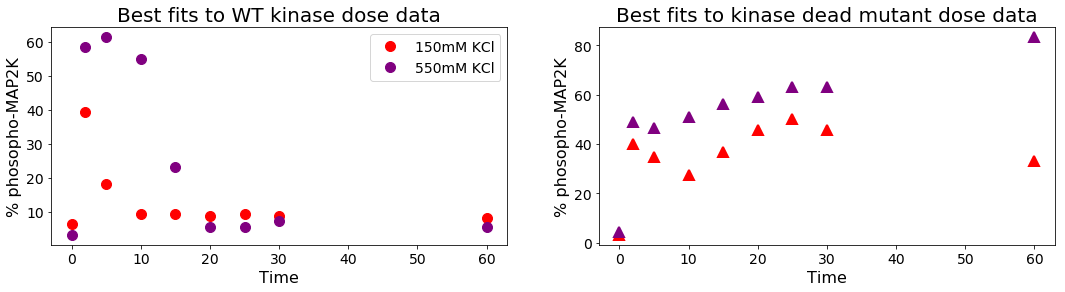

In [93]:
map2k_s = [150000, 550000]
params_constants_map2k = [MAP3K_t, MAP2K_t, MAPK_t, fb, map2k_s] 
plt_param_behaviors_map2k(map2k_wt_data, map2k_t100a_data, gen, idx_top, 10, params_from_file, 
                        params_constants_map2k, initals, time)

<Figure size 720x576 with 0 Axes>

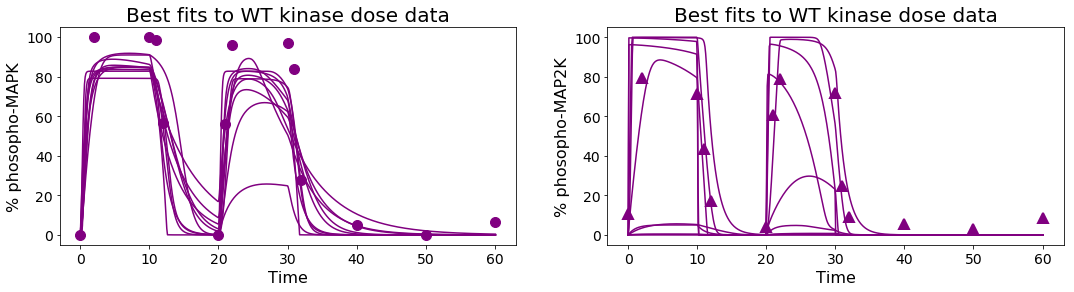

In [35]:
pulse_s = [550000]
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t, fb, pulse_s] 
plt_param_behaviors_pulse(hog1_pulse_data, pbs2_pulse_data, gen, idx_top, 10, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

<Figure size 720x576 with 0 Axes>

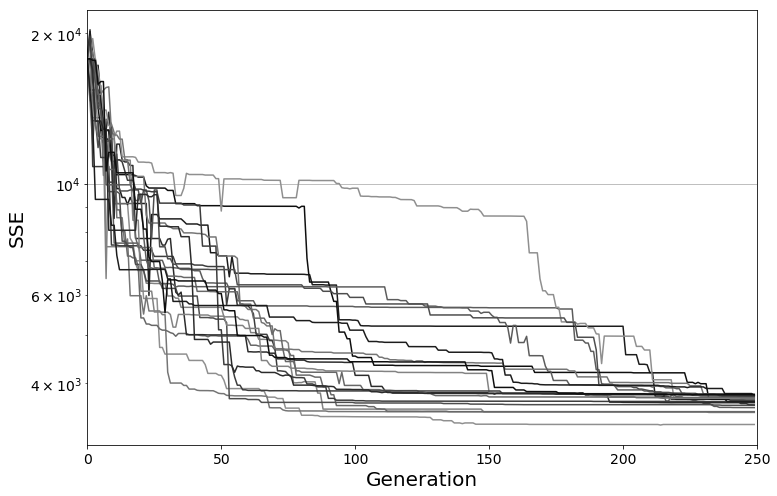

In [36]:
plt_mses_gen(gen,mse_aN_1D)

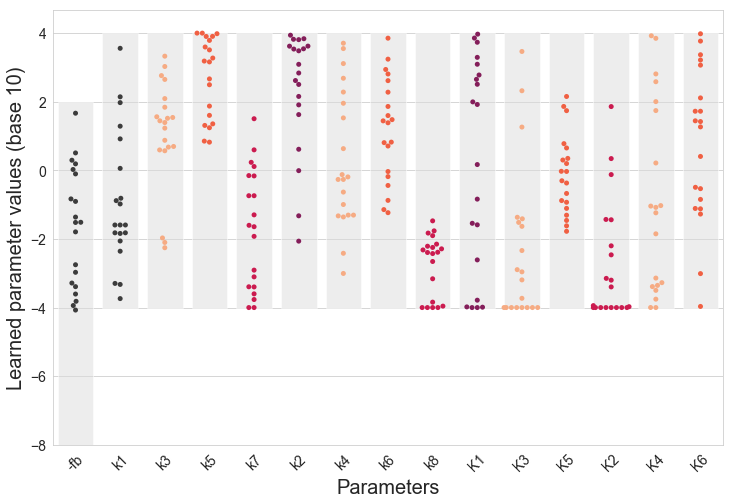

In [37]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] + rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(colors, labelnames, diff, minimums, df_top_params_log_M)

# of unstable WT experiments: 0 of 120
# of unstable T100A experiments: 0 of 120


<Figure size 864x576 with 0 Axes>

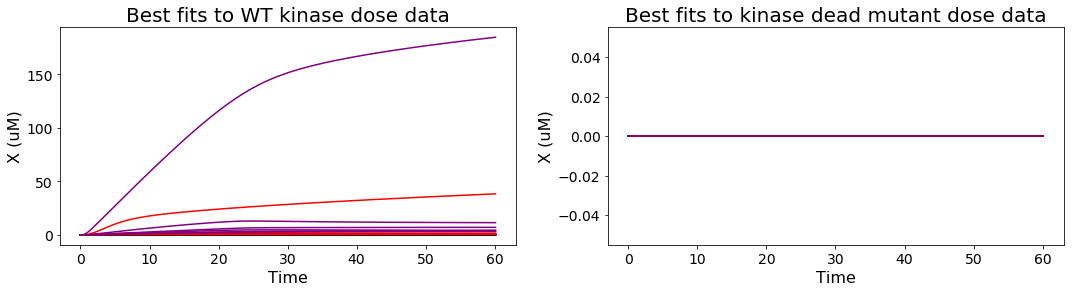

In [38]:
plt_X_behaviors(gen, idx_top, plt_top, params_from_file, 
                        params_constants_pulse, initals, time)

<Figure size 864x576 with 0 Axes>

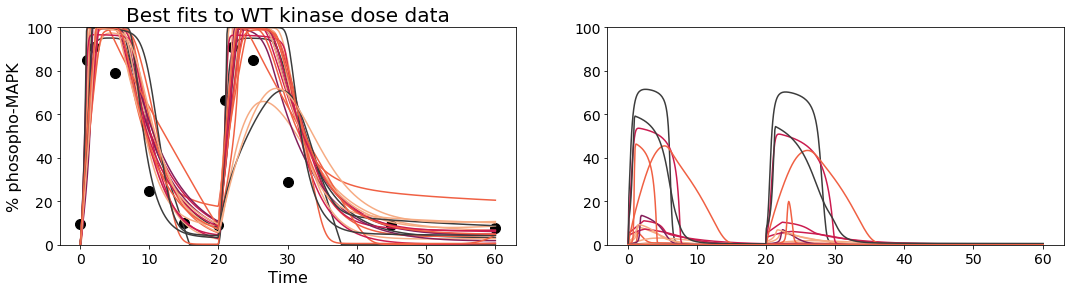

In [39]:
# pulse_s = [550000]
params_constants_pulse = [MAP3K_t, MAP2K_t, MAPK_t] 
plt_param_behaviors_ramp(hog1_ramp_data[0],gen,idx_top, 20, params_from_file, 
                        params_constants_pulse, initals,time)#scorefxn_time[2])

# Plot MSEs

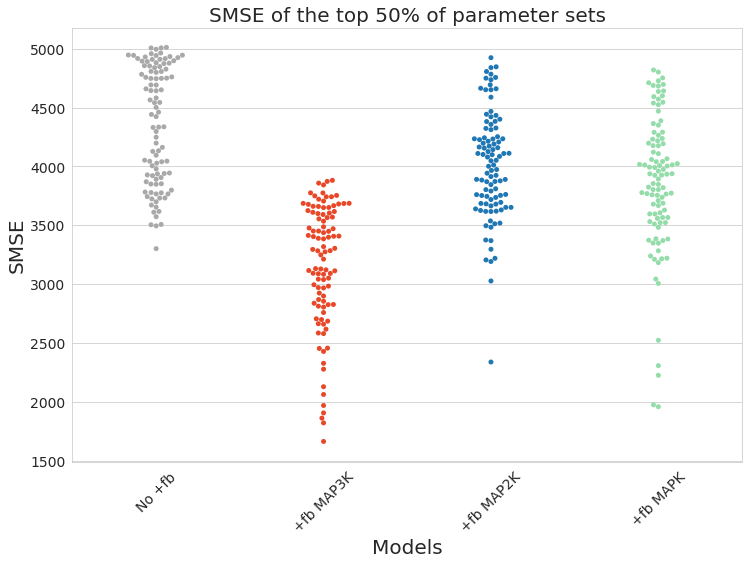

In [70]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_aN_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '1D')

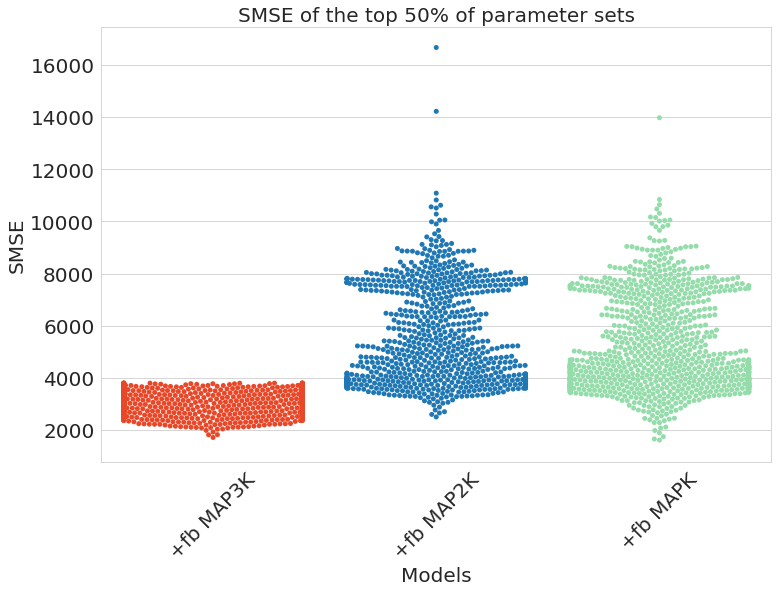

In [147]:
colors = ['#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D]        
plot_mses(['+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.5, colors, '1D')

In [ ]:
colors = ['#A9A9A9','#e84728','#1f77b4','#94ddaa']  
mses = [last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['No +fb', '+fb MAP3K', '+fb MAP2K', '+fb MAPK'], mses, 0.25, colors)

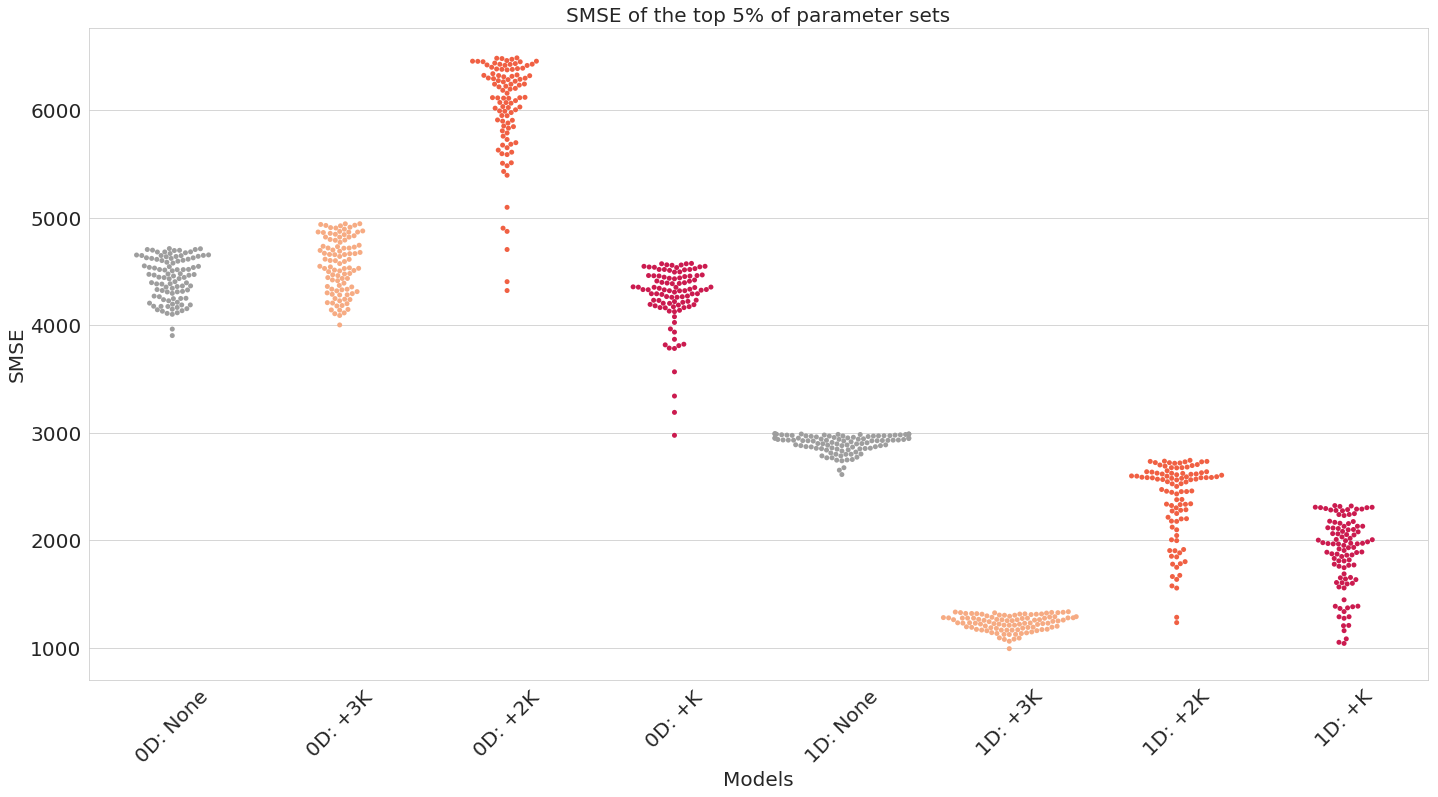

In [239]:
plt.rcParams['figure.figsize'] = [24.0, 12.0]
rocket = sns.color_palette("rocket", 5)#[::-1][:4]
rocket = rocket.as_hex()
rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [last_mses_aN_0D, last_mses_a3_0D, last_mses_a2_0D, last_mses_a1_0D, 
        last_mses_aN_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D] 
#         last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses(['0D: None', '0D: +3K', '0D: +2K', '0D: +K',
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K'],
#            '2D: None', '2D: +3K', '2D: +2K', '2D: +K'],
          mses, 0.05, colors,'mses_all')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/181024/mses_all.png",dpi=300)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\seaborn\categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


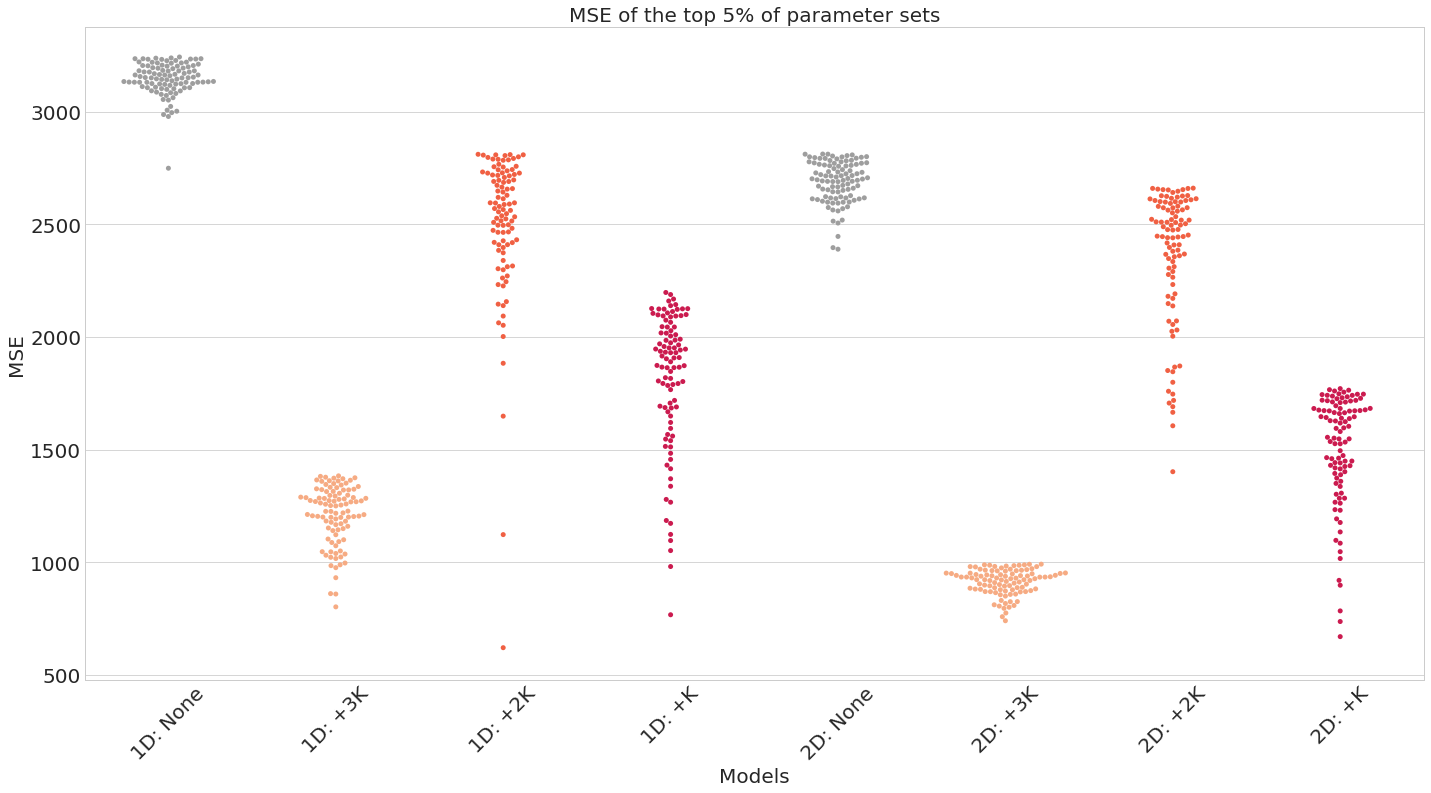

In [132]:
# plt.rcParams['figure.figsize'] = [24.0, 12.0]
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()
# rocket[::-1][:4]*4
colors = ['#9e9e9e'] + rocket[::-1][:3] + ['#9e9e9e'] + rocket[::-1][:3] 

# param_col = sns.set_palette(colors)

mses = [ 
        last_mses_an_1D, last_mses_a3_1D, last_mses_a2_1D, last_mses_a1_1D, 
        last_mses_an_2D, last_mses_a3_2D, last_mses_a2_2D, last_mses_a1_2D]        
plot_mses([
           '1D: None', '1D: +3K', '1D: +2K', '1D: +K',
           '2D: None', '2D: +3K', '2D: +2K', '2D: +K'], mses, 0.05, colors,'181024/mses_delay')